In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import tqdm
import torch
import torch.nn as nn
import dgl

Using backend: pytorch


In [2]:
import sys
sys.path.append("..")


from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from phenixml.labelers.fragment_labelers import BondFragmentLabeler,AngleFragmentLabeler
from phenixml.graphs.molgraph import MolGraph
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint

In [3]:
# # get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)
#containers = [MolContainer.from_rdkit(Chem.RemoveHs(container.rdkit_mol)) for container in containers]


# mol_dir = "/dev/shm/cschlick/COD_processing/COD_finalized"
# containers = MolContainer.from_folder(mol_dir,suffix=".mol")

In [4]:
molgraph = MolGraph(mol_container=containers[0],
                        fragmenter=BondFragmenter(),
                        labeler=BondFragmentLabeler(),
                        ignore_hydrogens=False)

In [5]:
molgraphs = []
for container in tqdm.tqdm(containers):
  try:
    molgraph = MolGraph(mol_container=container,
                        fragmenter=BondFragmenter(),
                        labeler=BondFragmentLabeler(),
                        ignore_hydrogens=False)
    # molgraph = MolGraph(container,
    #                 fragmenter=angle_fragmenter,
    #                 edge_fragmenter=bond_fragmenter,
    #                 fragment_labeler=angle_labeler,
    #                 frag_name = frag_name,
    #                 node_name = node_name,
    #                 connect_name = connect_name)
    molgraphs.append(molgraph)
  except:
    pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [06:52<00:00, 39.20it/s]


In [6]:
batch = dgl.batch([molgraph.heterograph for molgraph in molgraphs])

In [7]:
# model

#mine
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import JanossyReadout


n_units = 128
n_layers = 3
fragment_size = 2
feature_units = molgraphs[0].heterograph.nodes["atom"].data["h0"].shape[1]

config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
  
sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl sageconv layer

message_passing = MessagePassing(
    feature_units=feature_units,
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
    # atom_node_name = node_name,
    # fragment_name = frag_name,
) 


n_units = 128
n_layers = 2
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
readout = JanossyReadout(
    in_features=n_units, config=config,
    out_features={"pred":1},
    atom_node_name = "atom",
    fragment_name = "fragment",
    fragment_size = fragment_size
)
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)



In [8]:
def loss_fn(g):
  # a heterograph
  metric = torch.nn.MSELoss()
  loss = metric(g.nodes["fragment"].data["ref"],g.nodes["fragment"].data["pred"])
  return loss

In [9]:
batch = batch.to("cuda:1")
model = model.to("cuda:1")


In [10]:
epoch_losses = []
n_epoch=1000
avg_loss = "inf"

for epoch in tqdm.tqdm(range(n_epoch)):
    
  g = model(batch)
  loss = loss_fn(g)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:26<00:00,  3.06it/s]


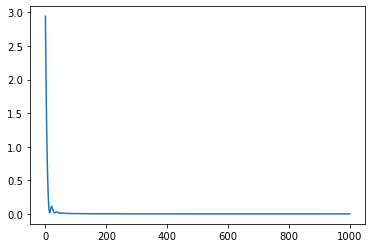

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)
#plt.plot(loss_history_n3[10:])

In [12]:
from phenixml.visualization.plotting import plot_geom_eval

In [13]:
a,b = g.nodes["fragment"].data["ref"], g.nodes["fragment"].data["pred"],
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)

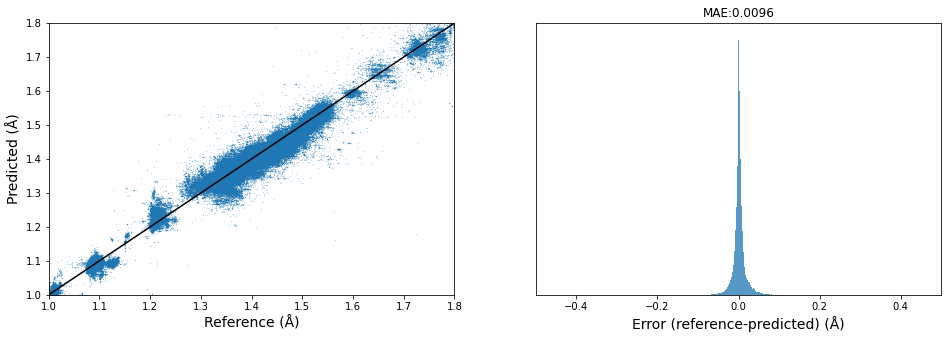

In [14]:
plot_geom_eval(a,b,mode="bond")